# Finding the K1 Most Demanding products using K-means algorithm.
The project has been clearly explained below along with 
- proper comments in the code, 
- Procedure, 
- Work done,
- Results obtained,
- Validaion and
- Conclusion.
<br>


We would like consider the explanation below is clear and be used as a report of our work done.<br>
Please have a look at the git repo for the dataset.<br>
Github repo-<br>
<a href='https://github.com/Yeshwanth-Reddyy/KMDP'>https://github.com/Yeshwanth-Reddyy/KMDP</a>

# Imports

In [1]:
"""
Created on 	: 12/10/19
Developer 	: Yeshwanth Reddy
File Type	: Python
"""

import pandas as pd
import numpy as np
import heapq
import random
import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt


# Introduction and Data Pre-Processing
Before Starting the project, we have the car dataset with all the "'d' no. of features of each car". Now, we need to generate the customers data based on these features.<br>
Along with all the feature details, we also know the class of a car (unacc, acc, good, vgood). So, we can use this data to create satisfaction bit stings for each car assuming we have 500 customers.<br>
I have used a random function and have chosen if a customer is satisfied by a product or not. If the car is of class vgood, then the random function gives 1 as output for 90% of times.<br>
vgood - 90%<br>
good - 75%<br>
acc - 50%<br>
unacc - 10%<br>

Using this technique, I have constructed a SBS table of dimensions 1728x575. The rows are the products and columns are the customers. It has been saved to a SBS.csv file in data_process folder.

In [2]:
""" Our Data format:                       """
#    buyingCost   v-high, high, med, low
#    maintCost    v-high, high, med, low
#    doors        2, 3, 4, 5-more
#    seats        2, 4, more
#    lug_boot     small, med, big
#    safety       low, med, high

# Create data file and creates a npArray "data" (uint8 format).
def create_Data(fileLocation = "./dataset/car/car.data"):
	print("Reading data...")
	data = pd.read_csv(fileLocation, header=None)
	data = np.array(data)
	print("Formatting data...")
	data[data=='5more'] = 5
	data[data=='vhigh'] = 3
	data[data=='more'] = 5
	data[data=='high'] = 2
	data[data=='big'] = 2
	data[data=='med'] = 1
	data[data=='low'] = 0
	data[data=='small'] = 0
	# Classes defining if a user BUYs or NOT.
	data[data=='unacc'] = 0
	data[data=='acc'] = 1
	data[data=='good'] = 2
	data[data=='vgood'] = 3
	data = np.array(data, dtype=np.uint8)
	np.random.shuffle(data)
	
	fileName = fileLocation.split("/")[-1].split(".")[0]
	pd.DataFrame(data, dtype=np.uint8).to_csv("./data_process/"+fileName+".csv", header=None, index=None)
	return data

# Creates and saves a "Satisfaction Bit String table" from the "data" for 500 customers.
def create_SBS(fileLocation="./dataset/car/car.data", data = create_Data()):
	no_cust = 500
	print("creating Empty SBS table...")
	SBS = np.zeros((data.shape[0], no_cust), dtype=np.uint8)
	
	print("Filling SBS table...")
	for i in range(SBS.shape[0]):
		for j in range(SBS.shape[1]):
			if data[i][-1] == 3: 	# 90% chance
				SBS[i][j]= 0 if random.randint(0,100)%10==0 else 1
			elif data[i][-1] == 2:  # 75% chance
				SBS[i][j]= 0 if random.randint(0,100)%4==0 else 1
			elif data[i][-1] == 1:  # 50% chance
				SBS[i][j]= 0 if random.randint(0,100)%2==0 else 1
			elif data[i][-1] == 0:  # 10% chance
				SBS[i][j]= 1 if random.randint(0,100)%10==0 else 0
	
	print("Saving to file...")
	fileName = fileLocation.split("/")[-1].split(".")[0]
	pd.DataFrame(SBS, dtype=np.uint8).to_csv("./data_process/"+fileName+"_SBS.csv", header=None, index=None)
	return SBS


# Reads data file and creates a npArray "data" (uint8 format).
def read_Data(fileLocation='./data_process/car.csv'):
	print("Reading data...")
	data = pd.read_csv(fileLocation, header=None)
	data = np.array(data, dtype=np.uint8)
	return data

# Reads the saved Satisfaction Bit String from saved file.
def read_SBS(SBSLocation='./data_process/car_SBS.csv'):
	print("Reading SBS...")
	SBS = pd.read_csv(SBSLocation, header=None)
	SBS = np.array(SBS, dtype=np.uint8)
	return SBS

Reading data...
Formatting data...


# K1MostDemandingProducts
There are 2 things.
- Predicting the satisfaction bit string(SBS) of a candidate product. <small>(done in pre-processing step)</small>.
- Predicting the k-most demanding products based on the SBS.

**Formulas Used:**-<br>
$C$ = {$c_0, c_1, c_2,....c_nc$}  -- Customers<br>
$EP$ = {$ep_0, ep_1, ep_2,....ep_nep$}  -- Existing products<br>
$CP$ = {$cp_0, cp_1, cp_2,....cp_ncp$}  -- Candidate products<br>
$kCP$ = {$kCP_1, kCP_2, kCP_3,....kCP_n$}  --  Set of Clusters<br>
$kCP_1$ = {$cp_0, cp_3, cp_5,....cp_9$}  --  Cluster of candidate products<br><br>

**(Counts no. of products a customer $c$ likes in the set of candidate products $CP$)**<br>
$N$($CP, c$) = return No. of products $c$ likes in set $CP$. <br><br>
**(Calculating the probability of a customer $c_j$ buying a candidate product $cp_i$)**<br>
$p$($cp_i, c_j$) = $\frac{1}{N(EP, c)+N(CP, c)}$ ------ if $c_j$ likes $cp_i$. <br>
$p$($cp_i, c_j$) = 0  -------------------------------------  otherwise<br><br>
**(Estimating the total buying probability of each product)**<br>
E($kCP, C$) = $\sum_{i=1}^{kcp} \sum_{j=1}^{C} p(cp_i, c_j)$ 


In [3]:
def N_Calc(SBS, EP, CP):
	cols = len(SBS[0])
	Nsbs = [[0]*2]*cols
	for i in range(cols):
		EP_count=0
		CP_count=0
		for j in EP:
			if SBS[j][i]==1:
				EP_count+=1
		for j in CP:
			if SBS[j][i]==1:
				CP_count+=1
		Nsbs[i][0] = EP_count
		Nsbs[i][1] = CP_count
	return Nsbs

def N(cust, Nsbs):
	EP_count = Nsbs[cust][0]
	CP_count = Nsbs[cust][1]
	return EP_count+CP_count

def P(cp_i, c_j, Nsbs, SBS):
	if SBS[cp_i][c_j]==1:
		p = 1 / N(c_j, Nsbs)
	else:
		p = 0
	return p

def E(kCP_n, C, Nsbs, SBS):
	E = 0
	for cp_i in kCP_n:
		for c_j in C:
			E += P(cp_i, c_j, Nsbs, SBS)
	return E


## Single product based Greedy algorithm

Let S denote a set containing a single candidate product cp in CP. <br>
The SPG algorithm uses E(S, C), which computes the expected number of the customers in C for S, as the ranking function of the candidate products. <br><br>
S = {$cp_0$}<br>
$p$($S, c_j$) = $\frac{1}{N(EP, c_j)+N(CP, c_j)}$ -- if $c_j$ likes S<br>
$p$($S, c_j$) = 0  -- otherwise<br><br>
E($S, C$) = $\sum_{j=1}^{C} p(S, c_j)$ 

The candidate products with the top-k values of the ranking function are selected to form an approximate solution of the k-MDP discovering problem.<br>
Algorithm 1: The SPG Algorithm <br>
Input: N_vector(EP,C), set C of customer requirements, set CP
of candidate product, and the value k <br>
Output: A set of k candidate product
``` python
def SPGA(k):
    for each candidate product cp in CP:
        """This is not needed as we already have it in our dataset."""
#         Compute the satisfaction bit string of cp;
        S={cp};
        Compute E(S,C);
        if i<=k
            Insert E(S,C) into the top-k list
        elif E(S,C)> the smallest value in top-k list
            Replace the smallest in top-k list with E(S,C);
        Put the corresponding candidate products in the top-k list to set the kCP;
    return kCP;
```

In [4]:
def SPG(k, SBS, EP, CP):
	k = [(0, 0)]*k
	heapq.heapify(k)
	Nsbs = N_Calc(SBS, EP, CP)
	for cp in CP:
		S = set()
		S.add(cp)
		e = E(S, C, Nsbs, SBS)
		heapq.heappush(k, (e, cp))
		heapq.heappop(k)
	return k


## Incremental Based Greedy Algorithm

Let S denotes an empty set initially. <br>
In each iteration, the IG algorithm selects one of the unselected candidate products cp, which has the maximum E(S $\bigcup$ {cp}, C) value. <br>
After inserting the selected candidate product into S, the values of the selection function for the unselected candidate products are recomputed in the following iteration to decide the next selected candidate product. <br>
The above process continues until k candidate products have been selected.<br>

Algorithm 2: The IG algorithm <br>
Input: N_vector(EP,C), set C of customer requirements, set CP of candidate product, and the value k <br>
Output: A set of k candidate product<br>

```python
def IG(k):
    """This is not needed as we already have the SBS in our dataset."""
#     for each candidate product cp in CP
#         Compute the satisfaction bit string of cp;
    S= null;
    while (|S| < k):
        max_E=0
        max_P=0
        for each candidate product cp in CP:
            temp_S = S U {cp};
            Compute E(temp_S,C);
            if ( E(temp_S,C) > max_E ):
                max_P={cp};
                max_E= E(temp_S,C)
        S=S U max_P;
        CP=CP – max_P; 

    return kCP;
```

In [5]:
def IG(k, SBS, EP, CP):
	S = np.array((),dtype=np.uint8)
	Nsbs = N_Calc(SBS, EP, CP)
	while(len(S) < k):
		max_E=0
		max_P=0
		for cp in CP:
			temp_S = np.append(S, cp)
			e = E(temp_S, C, Nsbs, SBS)
			if (e > max_E):
				max_E = e
				max_P = cp
		S = np.append(S, max_P)
		index = np.argwhere(CP==max_P)
		CP = np.delete(CP, index)
	return S


## Upper Bound Pruning Algorithm

Not Written yet.<br>

Algorithm 3: The UBP algorithm <br>
Input: k, SBS, EP, CP <br>
Output: A set of k candidate product<br>

```python
def UBP(k, SBS, EP, CP):
    return kCP;
```

In [6]:
def UBP(k, SBS, EP, CP):
  return k

# Main Code

In [7]:
# Taking K1 as 5
k=5

In [8]:
# Change the fileLocation to your car.data folder.
read_data_location = "./data_process/car.csv"
read_SBS_location = "./data_process/car_SBS.csv"
dataset_location = "./dataset/car/car.data"

# Creating the Satisfaction Bit String of every customer
try:
	data = read_Data(read_data_location) 
	SBS = read_SBS(read_SBS_location)
except:
	data = create_Data(dataset_location) 
	SBS = create_SBS(dataset_location, data)

Reading data...
Reading SBS...


In [9]:
rows=len(SBS)
cols=len(SBS[0])

# Creating Sets of Customers, Candidate Products and Existing Products.
C = np.arange(0, cols)
CP = np.arange(0, (rows*70)//100)
EP = np.arange((rows*70)//100, rows)
# kCP = ?

# SPGA
timeTaken = datetime.datetime.now()
SPG_k = SPG(k, SBS, EP, CP)
timeTaken = datetime.datetime.now() - timeTaken 
print("Single Product Based Greedy Algorithm : \n", SPG_k)
print("Time taken:", timeTaken.seconds)

# IG
timeTaken = datetime.datetime.now()
IG_k = IG(k, SBS, EP, CP)
timeTaken = datetime.datetime.now() - timeTaken
print("Incremental Based Greedy Algorithm : \n", IG_k)
print("Time taken:", timeTaken.seconds)

# # UBP
# timeTaken = datetime.datetime.now()
# UBP_k = UBP(k, SBS, EP, CP)
# timeTaken = datetime.datetime.now() - timeTaken
# print("Upper Bound Pruning Algorithm : \n", UBP_k)
# print("Time taken:", timeTaken.seconds)

Single Product Based Greedy Algorithm : 
 [(1.031818181818188, 601), (1.0409090909090968, 378), (1.0340909090909152, 1195), (1.0454545454545512, 1051), (1.0477272727272784, 540)]
Time taken: 5
Incremental Based Greedy Algorithm : 
 [ 540 1051  378 1195  457]
Time taken: 40


products selected by CSPG algo
194, 383, 871, 1051, 1195, 
products selected by CIG algo
1051, 1195, 871, 383, 194, 

## K-Means
Plotting the square error values for each no. of clusters.

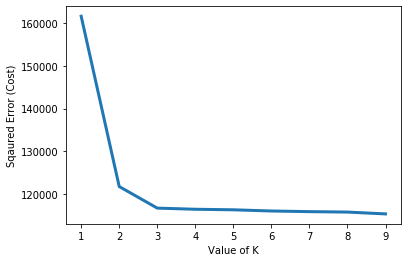

In [10]:
cost =[] 
# calculatig for 1-10 clusters
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 200) 
    KM.fit(SBS) 
    cost.append(KM.inertia_) 
# Plotting the cost function
plt.plot(range(1, 10), cost, linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

The error suddenly drops at 4 (clusters) and is almost constant for any higher number of clusters. So, we will be clustering our data into 5 clusters and the algorithms will be applied over one of the cluster.<br>
Generally, to select that one cluster, we pick 5-10% of our data, apply our algorithms over it and see from which cluster max no. of products were selected.<br>
By this, we can say that, this cluster consists of good products and runing our algorithm over this would provide best results.<br>
But here, our dataset is small and we are doing this only to verify if this technique works. So, we'll just skip the data picking step.

In [15]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data[CP])

# Cluster number of each datapoint
labels = list(kmeans.labels_)
# print(labels)

arr = [[] for i in range(n_clusters)]
for i,j in enumerate(labels):
	arr[j].append(i)

Clusters = [[] for i in range(n_clusters)]
for i in range(n_clusters):
	Clusters[i] = data[arr[i],:]
# Print the no. of products each cluster contains.
for i in range(n_clusters):
	print("%d: %d"% (i,len(Clusters[i])), end='\n')


# Cluster no of selected products.
selected_products = []
print("\nproducts selected by SPG algo")
for i in SPG_k:
	selected_products.append(labels[i[1]])
print(selected_products)
print("\nproducts selected by IG algo")
for i in IG_k:
	selected_products.append(labels[i])
print(selected_products)

0: 60
1: 51
2: 40
3: 34
4: 35

products selected by SPG algo


IndexError: list index out of range

In [19]:
print(SPG_k)
print(len(labels))
print(len(list(kmeans.labels_)))

[(1.031818181818188, 601), (1.0409090909090968, 378), (1.0340909090909152, 1195), (1.0454545454545512, 1051), (1.0477272727272784, 540)]
220
220


In the above case, majority of the products were selected from 4th cluster.<br>
So, we will run the algorithms once again over 4th cluster.

In [12]:
# Run over the cluster from which majority of the products have been selected previously.
cluster = max(set(selected_products), key = selected_products.count)
print(cluster)

SBS_New = SBS[arr[cluster]]
SBS_New = np.append(SBS_New, SBS[EP,:], axis=0)
h,w = SBS_New.shape

# Creating Sets of Customers, Candidate Products and Existing Products.
C = np.arange(0, w)
# CP = np.arange(0, (h*70)//100)
# EP = np.arange((h*70)//100, h)
CP = np.arange(0, len(Clusters[cluster]))
EP = np.arange(len(Clusters[cluster]), h)


# SPGA
timeTaken = datetime.datetime.now()
CSPG_k = SPG(k, SBS_New, EP, CP)
timeTaken = datetime.datetime.now() - timeTaken 
print("Single Product Based Greedy Algorithm : \n", CSPG_k)
print("Time taken:", timeTaken.seconds)

# IG
timeTaken = datetime.datetime.now()
CIG_k = IG(k, SBS_New, EP, CP)
timeTaken = datetime.datetime.now() - timeTaken
print("Incremental Based Greedy Algorithm : \n", CIG_k)
print("Time taken:", timeTaken.seconds)

# # UBP
# timeTaken = datetime.datetime.now()
# CUBP_k = UBP(k, SBS_New, EP, CP)
# timeTaken = datetime.datetime.now() - timeTaken
# print("Upper Bound Pruning Algorithm : \n", CUBP_k)
# print("Time taken:", timeTaken.seconds)

1
Single Product Based Greedy Algorithm : 
 [(2.5141242937853017, 94), (2.52542372881355, 69), (2.570621468926543, 217), (2.536723163841798, 51), (2.5875706214689154, 67)]
Time taken: 1
Incremental Based Greedy Algorithm : 
 [ 67 217  51  69  17]
Time taken: 7


In [13]:
print("\nproducts selected by CSPG algo")
for i in CSPG_k:
	print(arr[cluster][i[1]], end=', ')
print("\nproducts selected by CIG algo")
for i in CIG_k:
	print(arr[cluster][i], end=', ')


products selected by CSPG algo
526, 383, 1195, 301, 378, 
products selected by CIG algo
378, 1195, 301, 383, 98, 

# Conclusion
<b> Running over the whole data set</b> <br>
Single Product Based Greedy Algorithm : <br>
 [(0.995594713656393, 927), (0.9977973568281991, 601), (0.995594713656393, 1144), (1.0022026431718114, 830), (1.0088105726872296, 1119)]<br>
Time taken: 3 <br>
Incremental Based Greedy Algorithm : <br>
 [1119  830  601  927 1144] <br>
Time taken: 27 <br><br>

<b> Running over cluster 4</b> <br>
products selected by CSPG algo <br>
927, 601, 1144, 830, 1119,  <br>
Time taken: 0 <br>
products selected by CIG algo <br>
1119, 830, 601, 927, 1144,  <br>
Time taken: 2 <br>
<br>
As we can see, the results were the same in both cases and the time taken is very low when we apply over only one cluster.<br>
Thus KMDP can be optimised up to **10x** using K-means technique.

